# Load Data

In [199]:
from torch_geometric.datasets import Planetoid

In [200]:
dataset = Planetoid(root="/tmp/Cora", name="Cora")

## Cora
 - Citation Network
 - Node: Document
 - Edge: Citation
 - Label: Subject [NN, RL,...]
 - Feature: Bag-of-Words based

In [201]:
dataset.num_classes

7

In [202]:
dataset.num_features

1433

In [203]:
data = dataset[0]

```python
Data(
    x=[2708, 1433],                 ## Features
    edge_index=[2, 10556],          ## Edges
    y=[2708],                       ## Labels
    train_mask=[2708], val_mask=[2708], test_mask=[2708]
)
```

In [204]:
data.y[7]

tensor(3)

In [205]:
data.x[7]

tensor([0., 0., 0.,  ..., 0., 0., 0.])

## Train-, Val-, Testsplit
Split data into 3 disjunct Sets:
### Trainset
 - Used to train model 
 - NEVER use for Testing

### Validationset
 - Used to validate the performance after each epoch
 - Helps to prevent Overfitting
  
### Testdata
 - Unseen data
 - Used for testing AFTER training is complete

# Define Model

In [206]:
import torch.nn as nn
from torch.optim import Adam
import torch.nn.functional as F
from torch import no_grad

In [207]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(hidden_size, output_size)
    
    def forward(self, data):
        x = data.x
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        return x

## Activation Functions:
Define the behaviour of the Cells
 - ReLU
 - Softmax
 - Sigmoid


## Parameter
 - Trainable Weights in the model 
 - One weight per connection between layers

# Define Training Loop

In [ ]:
def run_training_without_optimizer(model,data, lr=0.01, epochs=200):    
    def train():
        model.train()
        model.zero_grad()  # Zero out gradients
        out = model(data)
        softmax = nn.Softmax(dim=1)
        out = softmax(out)
        loss = F.cross_entropy(out[data.train_mask], data.y[data.train_mask])
        loss.backward()

        # Manually update each parameter without an optimizer
        with no_grad():  # Temporarily set all tensors to non-grad mode
            for param in model.parameters():
                param -= lr * param.grad  # Update parameters
                param.grad.zero_()  # Clear gradients after update
        return float(loss), out

    def test():
        model.eval()
        pred = model(data).argmax(dim=-1)
        accs = []
        for mask in [data.train_mask, data.val_mask, data.test_mask]:
            accs.append(int((pred[mask] == data.y[mask]).sum()) / int(mask.sum()))
        return accs

    noop_train_acc_list, noop_val_acc_list, noop_test_acc_list = [], [], []
    best_val_acc = test_acc = 0
    for epoch in range(1, epochs + 1):
        loss, embedding = train()
        train_acc, val_acc, tmp_test_acc = test()
        noop_train_acc_list.append(train_acc)
        noop_val_acc_list.append(val_acc)
        noop_test_acc_list.append(tmp_test_acc)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            test_acc = tmp_test_acc
            noop_best_embedding = embedding
        if epoch == 1 or epoch == epochs: 
            print(f'Epoch: {epoch:03d}, Train: {train_acc:.4f}, Val: {val_acc:.4f}, Test: {test_acc:.4f}')
    
    return noop_train_acc_list, noop_val_acc_list, noop_test_acc_list, noop_best_embedding

## Loss Function
 - Here: loss = F.cross_entropy
 - Usually used for Classification
 - For Regression: Usually MSE

## Hyper Parameter
 - Can be set before training
 - Here: 
   - Learning Rate lr=0.01
   - hidden dimension
 - Also:
   - Weight Decay 
   - Batch-Size
   - ...

## Stochastic Gradiant Descent
 - Method to minimize loss
 - here: loss.backward()

## Train with optimizer

In [209]:
def run_training(model, data, lr=0.01, weight_decay=5e-4, epochs=200):
    optimizer = Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    def train():
        model.train()
        optimizer.zero_grad()
        out = model(data)
        embedding = out
        softmax = nn.Softmax(dim=1)
        out = softmax(out)
        loss = F.cross_entropy(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()
        return float(loss), embedding

    def test():
        model.eval()
        pred = model(data).argmax(dim=-1)
        accs = []
        for mask in [data.train_mask, data.val_mask, data.test_mask]:
            accs.append(int((pred[mask] == data.y[mask]).sum()) / int(mask.sum()))
        return accs

    train_acc_list, val_acc_list, test_acc_list = [], [], []
    best_val_acc = 0
    test_acc = 0  # Initialize test_acc to handle cases where val_acc might not improve
    for epoch in range(1, epochs + 1):
        loss, embedding = train()
        train_acc, val_acc, tmp_test_acc = test()
        train_acc_list.append(train_acc)
        val_acc_list.append(val_acc)
        test_acc_list.append(tmp_test_acc)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            test_acc = tmp_test_acc
            best_embedding = embedding
        if epoch == 1 or epoch == epochs: 
            print(f'Epoch: {epoch:03d}, Train: {train_acc:.4f}, Val: {val_acc:.4f}, Test: {test_acc:.4f}')
    return train_acc_list, val_acc_list, test_acc_list, best_embedding


# Initialize Model and run Training

In [210]:
mlp = MLP(input_size=dataset.num_features, hidden_size=16,
          output_size=dataset.num_classes)



In [211]:
noop_train_acc_list, noop_val_acc_list, noop_test_acc_list, noop_embedding = run_training_without_optimizer(mlp, data)

Epoch: 001, Train: 0.1429, Val: 0.0580, Test: 0.0640
Epoch: 200, Train: 0.1429, Val: 0.0580, Test: 0.0640


In [212]:
train_acc_list, val_acc_list, test_acc_list, embedding = run_training(mlp, data)

Epoch: 001, Train: 0.1643, Val: 0.0580, Test: 0.0640
Epoch: 200, Train: 1.0000, Val: 0.5540, Test: 0.5720


# Outlook


- Accuracy on Test barely 0.500
- GNN's outperfom this simple MLP by a landslide

# Visualization

## Using Matplotlib
Basic Visualization of a Line

In [213]:
import matplotlib.pyplot as plt

In [214]:
x = [i for i in range(len(noop_test_acc_list))]
y = noop_train_acc_list

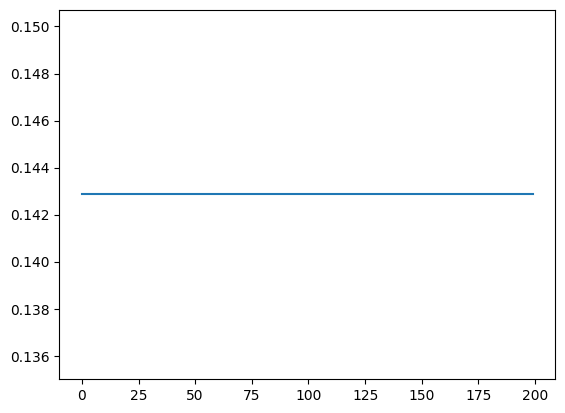

In [231]:
plt.plot(x, y)
plt.show()

### Adding Label and Legends

Text(0, 0.5, 'Accuracy')

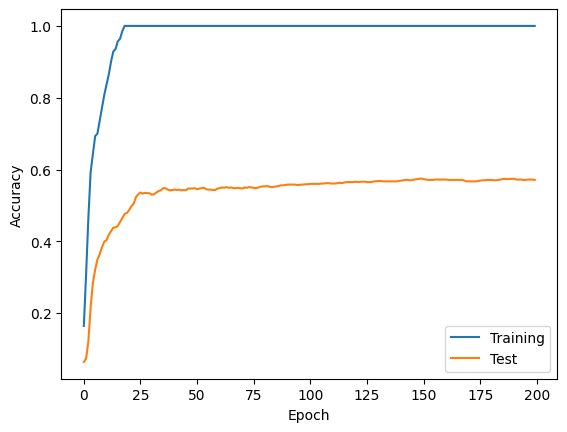

In [216]:
line1, = plt.plot(x, train_acc_list)
line1.set_label("Training")
line2, = plt.plot(x, test_acc_list)
line2.set_label("Test")

plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

### Manipulating the Scale

#### Control the number of ticks on the axis

Text(0, 0.5, 'Accuracy')

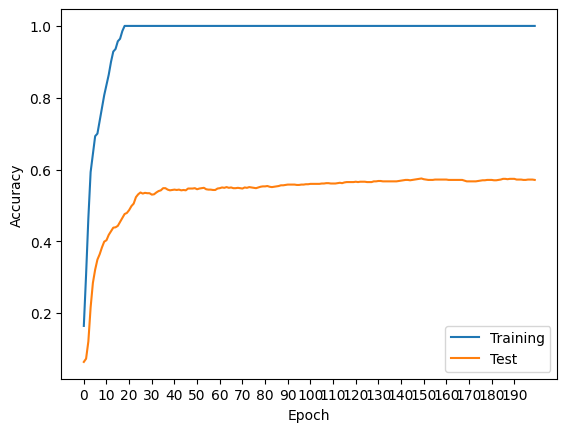

In [ ]:
line1, = plt.plot(x, train_acc_list)
line1.set_label("Training")
line2, = plt.plot(x, test_acc_list)
line2.set_label("Test")

plt.xticks(ticks=x[::10])

plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

#### Control the appearance

Text(0, 0.5, 'Accuracy')

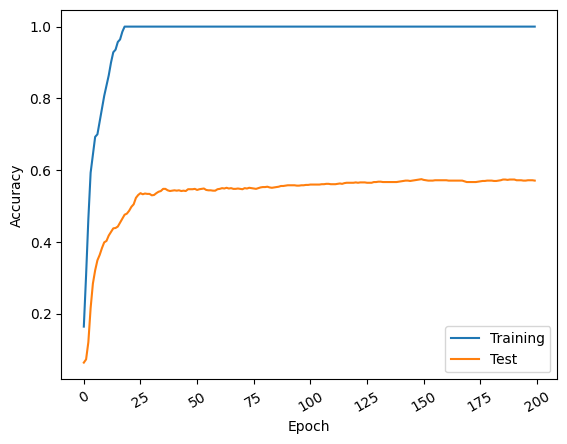

In [218]:
line1, = plt.plot(x, train_acc_list)
line1.set_label("Training")
line2, = plt.plot(x, test_acc_list)
line2.set_label("Test")

plt.xticks(rotation=30)

plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

## Seaborn
- [Examples on the Website](https://seaborn.pydata.org/examples/index.html)
- Simplifies visualizations. Pyplot still needed to make fine tunings

In [219]:
import seaborn as sns
import numpy as np

Text(0, 0.5, 'Accuracy')

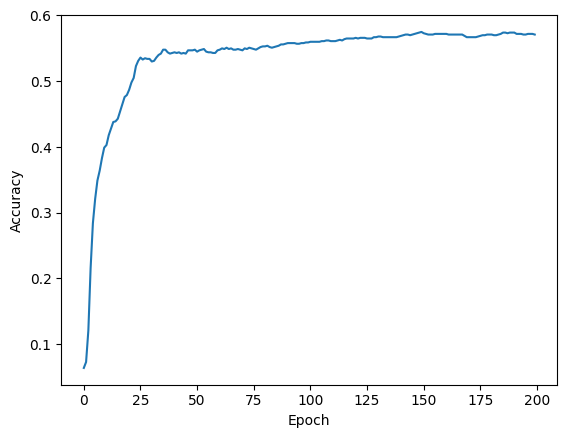

In [220]:
accuracy = sns.lineplot(x=x, y=test_acc_list)
accuracy.set_xlabel("Epoch")
accuracy.set_ylabel("Accuracy")

In [221]:
class_connections = np.zeros([7,7])
source, target =  data["edge_index"]
for i in range(len(source)):
    class_connections[data.y[source[i]], data.y[target[i]]] += 1

In [232]:
class_connections

array([[1.068e+03, 3.200e+01, 2.300e+01, 1.610e+02, 8.800e+01, 7.500e+01,
        8.000e+01],
       [3.200e+01, 8.180e+02, 6.200e+01, 6.700e+01, 2.000e+01, 2.800e+01,
        2.000e+00],
       [2.300e+01, 6.200e+01, 1.654e+03, 5.300e+01, 2.000e+00, 3.000e+01,
        2.000e+00],
       [1.610e+02, 6.700e+01, 5.300e+01, 2.350e+03, 1.370e+02, 5.400e+01,
        1.600e+01],
       [8.800e+01, 2.000e+01, 2.000e+00, 1.370e+02, 1.320e+03, 1.900e+01,
        6.000e+00],
       [7.500e+01, 2.800e+01, 3.000e+01, 5.400e+01, 1.900e+01, 8.340e+02,
        4.600e+01],
       [8.000e+01, 2.000e+00, 2.000e+00, 1.600e+01, 6.000e+00, 4.600e+01,
        5.060e+02]])

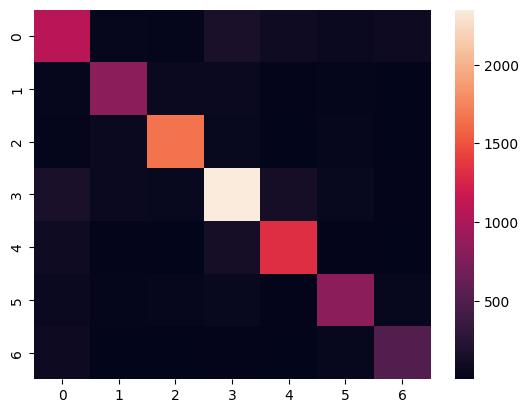

In [222]:
plot = sns.heatmap(class_connections)

### Scatterplot of the Embeddings using T-SNE

In [223]:
from sklearn.manifold import TSNE
import pandas as pd


In [224]:
# Example of your data and classes for demonstration
def _embedding_visualization_pyplot(embeddings, labels):
 
    # Apply t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    embeddings_2d = tsne.fit_transform(embeddings)

    # Use a color map to represent the 7 classes
    colors = plt.cm.get_cmap("tab10", 7)
    for i in range(7):  # Assuming labels are 0 through 6 for 7 classes
        idx = np.where(labels == i)
        plt.scatter(embeddings_2d[idx, 0], embeddings_2d[idx, 1], color=colors(i), label=f'Class {i}', alpha=0.6)
    
    plt.legend()
    plt.title('t-SNE Visualization of Embeddings')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.show()


In [225]:
def _embedding_visualization_seaborn(embeddings, labels):
 
    # Apply t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    embeddings_2d = tsne.fit_transform(embeddings)

    # Convert to DataFrame for seaborn
    df = pd.DataFrame({
        'TSNE-1': embeddings_2d[:, 0],
        'TSNE-2': embeddings_2d[:, 1],
        'Label': labels
    })
    
    sns.scatterplot(data=df, x='TSNE-1', y='TSNE-2', hue='Label', palette='tab10', alpha=0.6, s=70)   

    plt.legend()
    plt.title('t-SNE Visualization of Embeddings')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.show()
    return df

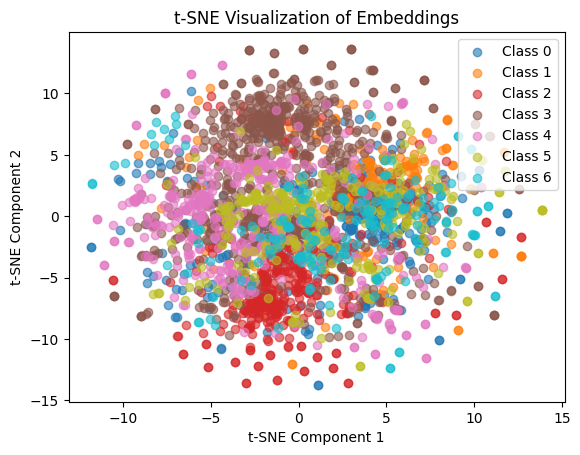

In [226]:
_embedding_visualization_pyplot(data.x, data.y)

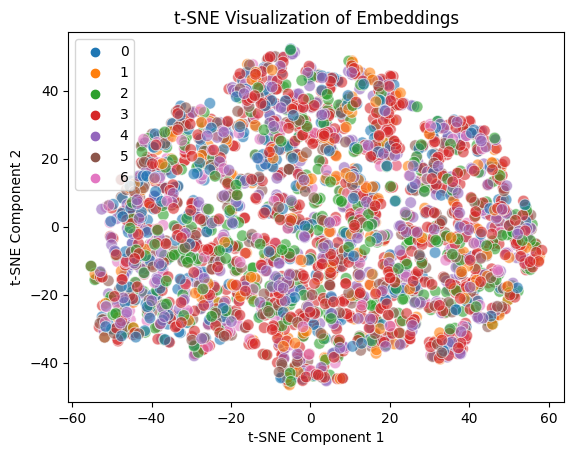

In [227]:
noop_df = _embedding_visualization_seaborn(noop_embedding.detach().numpy(), data.y)

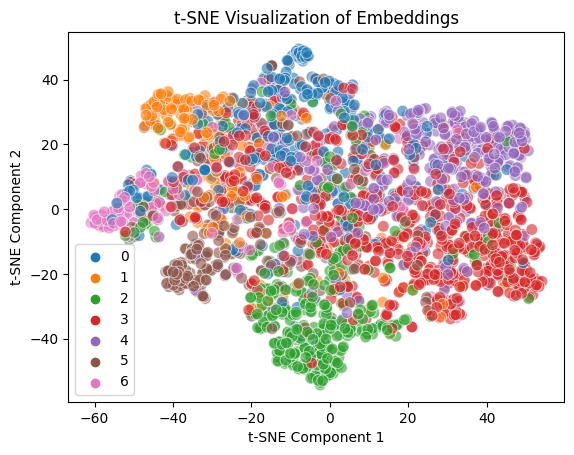

In [228]:
df = _embedding_visualization_seaborn(embedding.detach().numpy(), data.y)

In [229]:
df

,TSNE-1,TSNE-2,Label
0,48.671127,-24.040333,3
1,46.147259,23.107828,4
2,48.793938,24.563684,4
3,-7.620006,47.498650,0
4,51.102741,-24.059843,3
...,...,...,...
2703,33.166077,-24.012964,3
2704,2.649352,-24.020151,3
2705,-22.120110,5.495774,3
2706,47.616543,-8.041758,3


In [ ]:
justin.muecke@uni-ulm.de